# GNSS/ INS integration

Fusing GNSS and IMU measurements through an EKF is a common approach to improve the accuracy of the estimated state (Position and orientation). The following Python script fully implements from scratch all the necessary steps required for this fusion process.

## Importing packages

In [1]:
import numpy as np
import math as ma
import pandas as pd
import scipy.linalg
from scipy.interpolate import interp1d
import progressbar
import csv
import matplotlib.pyplot as plt
from pyproj import Transformer
import pyproj
import warnings
warnings.filterwarnings('ignore')
%matplotlib widget

## Defining transformation matrix, Attitude representation and skew matrix

In [2]:
RTOD = 180.0 / np.pi
DTOR = np.pi / 180.0

#Skew Matrix

def skew(a):

    # Skew semetric matrix
    #
    # INPUTS:
    #   a       3 by 1 vector of numbers
    #
    # OUTPUTS
    #   A       3 by 3 skew matrix

    A = np.array([[0.0, -a[2], a[1]],
                  [a[2], 0.0, -a[0]],
                  [-a[1], a[0], 0.0]], dtype=object)
    return A

#Attitude representation and tranformation from Euler angles to DCM and vice-versa

def RPY(eul):

    # Euler angle Diff EQ
    #
    # INPUTS:
    #   eul     3 by 1 set of Euler angles (phi, theta, psi) (rad)
    #
    # OUTPUTS
    #   A       3 by 3 matrix for Euler angle integration

    sin_phi = np.sin(eul[0])
    cos_phi = np.cos(eul[0])
    sin_theta = np.sin(eul[1])
    cos_theta = np.cos(eul[1])
    
    A = np.array([[1.0, sin_phi*sin_theta, cos_phi*sin_theta],
                  [0.0, cos_phi*cos_theta, -sin_phi*cos_theta],
                  [0.0, sin_phi, cos_phi]])
    A = 1.0/cos_theta*A
    return A


def CTM_to_Euler(C):

    # Compute Euler angles from transform matrix
    #
    # INPUTS:
    #   C     3 by 3 matrix C_b_n
    #
    # OUTPUTS
    #   Euler    Euler angle vector (phi, theta, psi) (rad)

    C = C.T  # change input so these are correct
    if(C[0,2]<-1):
        C[0,2] = -1
        print('less than -1')
    if(C[0,2]>1):
        C[0,2] = 1
        print('more than 1')
    phi = float(ma.atan2(C[1, 2], C[2, 2]))
    theta = float(-ma.asin(C[0, 2]))
    psi = float(ma.atan2(C[0, 1], C[0, 0]))
    Euler = np.zeros((1, 3))
    Euler = np.array([phi, theta, psi])
    return Euler


def Euler_to_CTM(eul):

    # Create Coordinate transform matrix
    #
    # INPUTS:
    #   eul     Euler angle vector (phi, theta, psi) (rad)
    #
    # OUTPUTS
    #   C.T     Body to Nav Rotation Matrix (no transpose is opposite)

    sin_phi = float(np.sin(eul[0]))
    cos_phi = float(np.cos(eul[0]))
    sin_theta = float(np.sin(eul[1]))
    cos_theta = float(np.cos(eul[1]))
    sin_psi = float(np.sin(eul[2]))
    cos_psi = float(np.cos(eul[2]))

    C = np.zeros((3, 3))
    C[0, 0] = cos_theta * cos_psi
    C[0, 1] = cos_theta * sin_psi
    C[0, 2] = -sin_theta
    C[1, 0] = -cos_phi * sin_psi + sin_phi * sin_theta * cos_psi
    C[1, 1] = cos_phi * cos_psi + sin_phi * sin_theta * sin_psi
    C[1, 2] = sin_phi * cos_theta
    C[2, 0] = sin_phi * sin_psi + cos_phi * sin_theta * cos_psi
    C[2, 1] = -sin_phi * cos_psi + cos_phi * sin_theta * sin_psi
    C[2, 2] = cos_phi * cos_theta
    return C.T  # body to NED

#Tranformation between the reference frames

def LLA_to_NED(lat, long, alt, x_ECEF, x_ref):

    # LLA to NED using reference
    #
    # INPUTS:
    #   lat     Lattitude (rad)
    #   long    Longitude (rad)
    #   alt     altitude (m)
    #   x_ECEF  Position of interest in ECEF frame (m)
    #   x_ref   Reference ECEF position for NED (m)
    #
    # OUTPUTS
    #   x_NED   Position in NED frame based on x_ref

    R_NED_to_ECEF = np.array([[-np.sin(lat)*np.cos(long),
                               -np.sin(long),
                               -np.cos(lat)*np.cos(long)],
                              [-np.sin(lat)*np.sin(long),
                               np.cos(long),
                               -np.cos(lat)*np.sin(long)],
                              [np.cos(lat),
                               0.0,
                               -np.sin(lat)]])
    residual = np.array([[float(x_ECEF[0])-float(x_ref[0])],
                         [float(x_ECEF[1])-float(x_ref[1])],
                         [float(x_ECEF[2])-float(x_ref[2])]])
    x_NED = np.matmul(R_NED_to_ECEF.T, residual)
    return(x_NED)


def ECEF_to_LLA(r_eb_e):

    # ECEF to LLA frame
    #
    # INPUTS:
    #   r_eb_e  ECEF frame coordinate (m)
    #
    # OUTPUTS
    #   lat     Lattitude (rad)
    #   long    Longitude (rad)
    #   alt     altitude (m)

    f = 1.0/298.257223563
    R0 = 6378137.0
    e = np.sqrt(f*(2.0-f))
    R_P = R0*(1.0-f)
    long = ma.atan2(r_eb_e[1], r_eb_e[0])
    p = np.sqrt(r_eb_e[0]**2+r_eb_e[1]**2)
    E = np.sqrt(R0**2-R_P**2)
    F = 54.0*(R_P*r_eb_e[2])**2
    G = p**2+(1.0-e**2)*r_eb_e[2]**2-(e*E)**2
    c = e**4*F*p**2/(G**3)
    s = (1.0+c+np.sqrt(c**2+2*c))**(1.0/3.0)
    P = (F/(3*G**2))/((s+1.0/s+1.0)**2)
    Q = np.sqrt(1.0+2.0*e**4*P)
    k1 = (-P*e**2*p)/(1.0+Q)
    k2 = 0.5*R0**2*(1.0+1.0/Q)
    k3 = -P*(1.0-e**2)*(r_eb_e[2]**2)/(Q*(1.0+Q))
    k4 = -0.5*P*p**2
    k5 = p-e**2*(k1+np.sqrt(k2+k3+k4))
    U = np.sqrt(k5**2+r_eb_e[2]**2)
    V = np.sqrt(k5**2+(1.0-e**2)*r_eb_e[2]**2)
    alt = U*(1.0-R_P**2/(R0*V))
    z0 = (R_P**2*r_eb_e[2])/(R0*V)
    ep = R0*e/R_P
    lat = ma.atan((r_eb_e[2]+z0*ep**2)/p)
    return lat, long, alt


def LLA_to_ECEF(lat, long, alt):

    # LLA to ECEF frame
    #
    # INPUTS:
    #   lat     Lattitude (rad)
    #   long    Longitude (rad)
    #   alt     altitude (m)
    #
    # OUTPUTS
    #   x   ECEF x position (m)
    #   y   ECEF y position (m)
    #   z   ECEF z position (m)

    R0 = 6378137.0  # WGS84 Equatorial radius in meters
    f = 1/298.257223563
    e = np.sqrt(f*(2.0 - f))  # WGS84 eccentricity
    # calculate transverse radius of curvature (2.105)
    R_E = R0 / np.sqrt(1.0-(e*np.sin(lat))**2)
    # Convert position using (2.112)
    cos_lat = np.cos(lat)
    sin_lat = np.sin(lat)
    cos_long = np.cos(long)
    sin_long = np.sin(long)
    r_eb_e = np.array([[(R_E + alt) * cos_lat * cos_long],
                       [(R_E + alt) * cos_lat * sin_long],
                       [((1.0 - e**2) * R_E + alt) * sin_lat]])   #convert llh to x/y/z ECEF fram
    x = r_eb_e[0]
    y = r_eb_e[1]
    z = r_eb_e[2]
    return x, y, z

def ECEF_to_NED(x_ecef, latR, longR, alt):

    # ECEF to NED frame (Using differnt method)
    #
    # INPUTS:
    #   x_ecef  ECEF position of interest (m)
    #   lat     Lattitude (rad)
    #   long    Longitude (rad)
    #   alt     altitude (m)
    #
    # OUTPUTS
    #   NED     NED position based on LLA coordinates (m)

    x, y, z = LLA_to_ECEF(latR, longR, alt)
    ref_e = np.array([x, y, z])
    delta_E = np.zeros((3, 1))
    delta_E[0] = x_ecef[0] - ref_e[0]
    delta_E[1] = x_ecef[1] - ref_e[1]
    delta_E[2] = x_ecef[2] - ref_e[2]
    ENU = np.zeros((3, 1))
    ENU[0] = -np.sin(longR)*delta_E[0] + np.cos(longR)*delta_E[1]
    ENU[1] = -np.sin(latR)*np.cos(longR)*delta_E[0] - np.sin(latR)*np.sin(longR)*delta_E[1] + np.cos(latR)*delta_E[2]
    ENU[2] = -np.cos(latR)*np.cos(longR)*delta_E[0] + np.cos(latR)*np.sin(longR)*delta_E[1] + np.sin(latR)*delta_E[2]
    C = np.zeros((3, 3))
    C[0, 1] = 1.0   # ENU to NED Rotation Matrix
    C[1, 0] = 1.0
    C[2, 2] = -1.0
    NED = np.zeros((3, 1))
    NED = C@ENU
    return NED

def ECI_to_ECEF(xp, yp, Omega, i):

    # ECI to ECEF frame
    #
    # INPUTS:
    #   xp
    #   yp
    #   Omega
    #   i
    #
    # OUTPUTS
    #   r_eb_e  ECEF frame coordinate (m)

    x = xp*ma.cos(Omega) - yp*ma.cos(i)*ma.sin(Omega)
    y = xp*ma.sin(Omega) + yp*ma.cos(i)*ma.cos(Omega)
    z = yp*ma.sin(i)
    r_eb_e = np.array([x, y, z])
    return r_eb_e

## Import and Read GNSS & IMU measurements

In [3]:
#Defining some constants

DTOR = np.pi / 180.0  # degrees to radians
f = 1.0/298.257223563  #Wgs84 Earth flatenning factor
earth_rad = 6378137.0  # Earth's radius (m)
omega_ie = 7.2921151467E-05  # Earth ROT rate (rad/s)
mu = 3.986005E14  # m^3/s^2    mass of earth

# Read GNSS & IMU data

def get_PPK_GNSS_data(folder):
    # col 0: Week Number
    # col 1: Time
    # col 2: lat [ECEF]
    # col 3" lon [ECEF]
    # col 4: height [ECEF]
    # col 5-14: RTK Quality and Correlation Data
    # col 15:  North x_dot (m/s)
    # col 16:  East x_dot (m/s)
    # col 17:  Down x_dot (m/s)
    Table_data = pd.read_table(folder+'/5905C00224202112030934-5905C00224202112031022.pos',
                               sep='\s+',header=None,comment='%')
    gps_data = Table_data.iloc[:,[1,2,3,4,5, 6, 7, 15,16,17, 18, 19, 20]]
    gps_data.columns = ['time (sec)', 'Lat (rad)', 'Long (rad)', 'Alt (m)', 'sdn(m)', 'sde(m)', 'sdu(m)', 'v_N (m/s)', 'v_E (m/s)', 'v_D (m/s)', 'sdvn', 'sdve', 'sdvu']
    
    return gps_data


def get_IMU_data(folder):
    # col 0: time (sec)
    # col 4: meas_omega_ib_b P (rad/s)
    # col 5: meas_omega_ib_b Q (rad/s)
    # col 6: meas_omega_ib_b R (rad/s)
    # col 7: meas_f_ib_b X (m/s^2)
    # col 8: meas_f_ib_b Y (m/s^2)
    # col 9: meas_f_ib_b Z (m/s^2)
    IMU_data = pd.read_csv(folder+'/IMU_Data.csv',
                           sep=';')
    return IMU_data

In [4]:
#test
folder='C:/Users/bourriz/GNSS_INS_Processing/UIS_PosPac_HyspexNav_processing/Result/Position'
get_PPK_GNSS_data(folder).head()

,time (sec),Lat (rad),Long (rad),Alt (m),sdn(m),sde(m),sdu(m),v_N (m/s),v_E (m/s),v_D (m/s),sdvn,sdve,sdvu
0,466543.4,-21.241363,14.876887,901.7170,4,3,4.0148,-1.03204,1.91748,0.08522,2.26644,3.64198,10.23567
1,466543.6,-21.241365,14.876892,901.7332,4,3,3.7037,-0.33353,0.53270,0.02729,2.10978,3.38555,9.78956
2,466544.2,-21.241366,14.876893,901.7352,4,3,2.9174,0.01021,-0.04879,0.00073,1.38262,2.62462,8.48690
3,466544.4,-21.241366,14.876893,901.7354,4,3,2.6713,0.02707,-0.00883,0.00085,1.31835,2.49828,8.06588
4,466544.6,-21.241366,14.876893,901.7355,4,3,2.4379,-0.00599,0.04072,0.00218,1.25539,2.37423,7.65196


## Organize and synchronize the GNSS and IMU data into a single file 

In [5]:
def get_all_INS_GNSS_data(flag):
    
    #Defining the mounting
    
    mounting = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]) 
    mounting_g = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    

    GNSS_LLA_VEL_data = get_PPK_GNSS_data(folder)

    IMU_data = get_IMU_data(folder)
    
    GNSS_Data_count = len(GNSS_LLA_VEL_data)
    
    ins_Data_count = len(IMU_data)
    Profile_Data_Count = np.max([GNSS_Data_count, ins_Data_count])

    # Set up and fill vectors/matrices
    meas_GNSS_pos_lla = np.zeros((GNSS_Data_count, 3))
    meas_GNSS_vel_ned = np.zeros((GNSS_Data_count, 3))
    meas_omega_ib_b = np.zeros((ins_Data_count, 3))
    meas_omega_r = np.zeros((ins_Data_count))
    meas_omega_p = np.zeros((ins_Data_count))
    meas_omega_y = np.zeros((ins_Data_count))
    meas_f_ib_b = np.zeros((ins_Data_count, 3))
    in_profile_data = np.zeros((Profile_Data_Count, 16))  # Input data array

    time_series = IMU_data.loc[:]['Time'].to_numpy()
    meas_omega_r[:] = IMU_data.loc[:]['roll'].to_numpy()  # Meas roll rate
    meas_omega_p[:] = IMU_data.loc[:]['pitch'].to_numpy()  # Meas pitch rate
    meas_omega_y[:] = IMU_data.loc[:]['heading'].to_numpy()  # Meas yaw rate

    
    meas_omega_ib_b[:, 0] = IMU_data.loc[:]['Xang'].to_numpy()  # Meas roll rate
    meas_omega_ib_b[:, 1] = IMU_data.loc[:]['Yang'].to_numpy()  # Meas pitch rate
    meas_omega_ib_b[:, 2] = IMU_data.loc[:]['Zang'].to_numpy()  # Meas yaw rate
    meas_f_ib_b[:, 0] = IMU_data.loc[:]['Xacc'].to_numpy()  # Measured X accel in body axis
    meas_f_ib_b[:, 1] = IMU_data.loc[:]['Yacc'].to_numpy()  # Measured Y accel
    meas_f_ib_b[:, 2] = IMU_data.loc[:]['Zacc'].to_numpy()  # Measured Z accel

    meas_f_ib_b = meas_f_ib_b @ mounting                 # change the orientation according to the mounting of the IMU (180,0,90)
    meas_omega_ib_b = meas_omega_ib_b @ mounting_g


    meas_GNSS_time = GNSS_LLA_VEL_data.loc[:]['time (sec)'].to_numpy()

    meas_GNSS_pos_lla[:, 0] = GNSS_LLA_VEL_data.loc[:]['Lat (rad)'].to_numpy()
    meas_GNSS_pos_lla[:, 1] = GNSS_LLA_VEL_data.loc[:]['Long (rad)'].to_numpy()
    meas_GNSS_pos_lla[:, 2] = GNSS_LLA_VEL_data.loc[:]['Alt (m)'].to_numpy()

    meas_GNSS_vel_ned[:, 0] = GNSS_LLA_VEL_data.loc[:]['v_N (m/s)'].to_numpy()
    meas_GNSS_vel_ned[:, 1] = GNSS_LLA_VEL_data.loc[:]['v_E (m/s)'].to_numpy()
    meas_GNSS_vel_ned[:, 2] = GNSS_LLA_VEL_data.loc[:]['v_D (m/s)'].to_numpy()

   
    #Estimate the gyro and acc biais from the 1st measurements
    
    GNSS_Time_index = 0
    INS_Time_index = 0
    index = 0
    InitP_acc_bias = np.array((0.0,0,0))
    InitP_acc_b_sigma = 0
    InitP_gyro_bias = np.array((0.0,0,0))
    InitP_gyro_b_sigma = 0
    i=0
    StartTime = np.max([meas_GNSS_time[0], time_series[0]])
    StartTime = 467000

    while(time_series[INS_Time_index] < StartTime) :
        InitP_acc_bias += meas_f_ib_b[INS_Time_index]
        InitP_acc_b_sigma += ma.sqrt((meas_f_ib_b[INS_Time_index] - InitP_acc_bias)@(meas_f_ib_b[INS_Time_index] - InitP_acc_bias).T)/3
        InitP_gyro_bias += meas_omega_ib_b[INS_Time_index]
        InitP_gyro_b_sigma += ma.sqrt((meas_omega_ib_b[INS_Time_index] - InitP_gyro_bias)@(meas_omega_ib_b[INS_Time_index] - InitP_gyro_bias).T)/3
        
        INS_Time_index += 1

    GNSS_POS_Sigma = 0.0
    GNSS_POS_Sigma = GNSS_LLA_VEL_data.loc[GNSS_Time_index+1]['sdn(m)'] **2 + GNSS_LLA_VEL_data.loc[GNSS_Time_index]['sde(m)'] **2 + GNSS_LLA_VEL_data.loc[GNSS_Time_index]['sdu(m)'] **2
    GNSS_POS_Sigma = ma.sqrt(GNSS_POS_Sigma)
    GNSS_VEL_Sigma = GNSS_LLA_VEL_data.loc[GNSS_Time_index]['sdvn'] **2 + GNSS_LLA_VEL_data.loc[GNSS_Time_index]['sdve'] **2 + GNSS_LLA_VEL_data.loc[GNSS_Time_index]['sdvu'] **2
    GNSS_VEL_Sigma = ma.sqrt(GNSS_VEL_Sigma)

    InitP_acc_bias /= INS_Time_index
    InitP_gyro_bias /= INS_Time_index
    InitP_acc_b_sigma /= INS_Time_index
    InitP_gyro_b_sigma /= INS_Time_index

    InitP =  np.array((GNSS_POS_Sigma, GNSS_VEL_Sigma , InitP_acc_bias, InitP_acc_b_sigma , InitP_gyro_bias, InitP_gyro_b_sigma )) 
    
    # Gravity accel in NED frame
    dum1 = (1.0 + 0.0019311853*(np.sin(meas_GNSS_pos_lla[0, 0]))**2.0)
    g0 = 9.7803253359/np.sqrt(1-f*(2.0-f)*(np.sin(meas_GNSS_pos_lla[0, 0]))**2.0)*dum1   #WGS84 gravity value for different lats
    dum2 = 3.0*(meas_GNSS_pos_lla[0, 2]/earth_rad)**2.0                                   # 3 x (altitude/radius)^2
    ch = 1.0-2.0*(1.0+f+(earth_rad**3.0*(1-f)*omega_ie**2.0)/(mu))*(meas_GNSS_pos_lla[0, 2]/earth_rad)+dum2 # altitude factor

    while(meas_GNSS_time[GNSS_Time_index] < StartTime) :
        GNSS_Time_index += 1

    while(time_series[INS_Time_index] < StartTime) :
        INS_Time_index += 1

    #Time is synced now
    while (GNSS_Time_index < GNSS_Data_count) and (INS_Time_index < ins_Data_count):
 
           
        in_profile_data[index][0] = time_series[INS_Time_index]
        
        rpy = mounting@np.array([meas_omega_r[INS_Time_index]*DTOR, meas_omega_p[INS_Time_index]*DTOR, meas_omega_y[INS_Time_index]*DTOR])
        g_f_ctm =Euler_to_CTM(np.array([rpy[0], rpy[1], rpy[2]]))
        g_f_b = g_f_ctm.T@np.array([0,0,ch*g0])

        in_profile_data[index][1] = meas_GNSS_pos_lla[GNSS_Time_index, 0]*DTOR   #Lat/Lon were in degrees that are to be converted to radians 
        in_profile_data[index][2] = meas_GNSS_pos_lla[GNSS_Time_index, 1]*DTOR
        in_profile_data[index][3] = meas_GNSS_pos_lla[GNSS_Time_index, 2]
        in_profile_data[index][4] = meas_GNSS_vel_ned[GNSS_Time_index, 0]
        in_profile_data[index][5] = meas_GNSS_vel_ned[GNSS_Time_index, 1]
        in_profile_data[index][6] = meas_GNSS_vel_ned[GNSS_Time_index, 2]
        in_profile_data[index][7] = meas_omega_ib_b[INS_Time_index, 0]
        in_profile_data[index][8] = meas_omega_ib_b[INS_Time_index, 1]
        in_profile_data[index][9] = meas_omega_ib_b[INS_Time_index, 2]
        in_profile_data[index][10] = meas_f_ib_b[INS_Time_index, 0]+g_f_b[0]
        in_profile_data[index][11] = meas_f_ib_b[INS_Time_index, 1]+g_f_b[1]
        in_profile_data[index][12] = meas_f_ib_b[INS_Time_index, 2]+g_f_b[2]
        in_profile_data[index][13:16] = rpy
        
        if (meas_GNSS_time[GNSS_Time_index] < time_series[INS_Time_index]):
            GNSS_Time_index += 1
        index += 1
        INS_Time_index += 1
        if time_series[INS_Time_index] > 469440:
            break;
    
    if flag is True:
        # Plot data
        fig, a = plt.subplots(2, figsize=(10, 10),sharex=True)
        a[0].plot(time_series, meas_omega_ib_b[:, 0], 'b',
                  label='Meas. Roll Rate')
        a[0].plot(time_series, meas_omega_ib_b[:, 1], 'k',
                  label='Meas. Pitch Rate')
        a[0].plot(time_series, meas_omega_ib_b[:, 2], 'r',
                  label='Meas. Yaw Rate')
        a[0].grid()
        a[0].set_ylabel('Angular Velocity (rad/s)')
        a[0].legend()

        a[1].plot(time_series, meas_f_ib_b[:, 0], 'b',
                  label='Meas. X accel')
        a[1].plot(time_series, meas_f_ib_b[:, 1], 'k',
                  label='Meas. Y accel')
        a[1].plot(time_series, meas_f_ib_b[:, 2], 'r',
                  label='Meas. Z accel')
        a[1].grid()
        a[1].set_ylabel('Acceleration (m/s^2)')
        a[1].legend()

        fig.suptitle('IMU measurements')
        in_profile_data[index][13:16] = rpy
        plt.show()
    return index, in_profile_data, InitP

## Define the Mechanization Equations

In [6]:
RTOD = 180.0 / np.pi
DTOR = np.pi / 180.0
a = 6378137.0  # Earth's radius (m)
f = 1.0/298.257223563  #Wgs84 Earth flatenning factor
e = np.sqrt(f*(2.0-f))    #Eccentricity
mu = 3.986005E14  # m^3/s^2    mass of earth
omega_ie = 7.2921151467E-05  # Earth ROT rate (rad/s)


def INS_Equations_NED(tor_i, old_latR, old_longR, old_alt, old_v_eb_n,
                      old_C_b_n, meas_omega_ib_b, meas_f_ib_b, meas_heading_n):

    # INS update Equations from k-1 to k
    #
    # INPUTS:
    #   tor_i               Delta T (In this instant, INS Hz Rate) (sec)
    #   old_latR            Previous estimate Latitude (rad)
    #   old_longR           Previous estimate Longtiude (rad)
    #   old_alt             Previous estimate altitude (m)
    #   old_v_eb_n          Previous estimate velocity (m/sec)
    #   old_C_b_n           Previous estimate DCM Matrix
    #   meas_omega_ib_b     Previous body angular velocity (rad/sec)
    #   meas_f_ib_b         Previous body acceleration (m/sec^2)
    #
    # OUTPUTS
    #   new_C_b_n       INS estimate DCM Matrix
    #   new_v_eb_n      INS estimate velocity (m/sec)
    #   new_latR        INS estimate Latitude (rad)
    #   new_longR       INS estimate Longtiude (rad)
    #   new_alt         INS estimate altitude (m)

    # Gravity accel in NED frame
    dum1 = (1.0 + 0.0019311853*(np.sin(old_latR))**2.0)
    g0 = 9.7803253359/np.sqrt(1-f*(2.0-f)*(np.sin(old_latR))**2.0)*dum1   #WGS84 gravity value for different lats
    dum2 = 3.0*(old_alt/a)**2.0                                   # 3 x (altitude/radius)^2
    ch = 1.0-2.0*(1.0+f+(a**3.0*(1-f)*omega_ie**2.0)/(mu))*(old_alt/a)+dum2 # altitude factor
    g_n = np.array([0.0, 0.0, ch*g0])

    # Earth rotation rate expressed in navigation frame
    omega_ie_n = omega_ie*np.array([np.cos(old_latR), 0.0, -np.sin(old_latR)]) # Earth rotation rate for the lats

    # Transport Rate
    RN = a*(1.0-e**2)/(1.0-e**2.0*(np.sin(old_latR))**2.0)**1.5
    RE = a/np.sqrt(1.0-e**2.0*(np.sin(old_latR))**2.0)
    dum4 = float(old_v_eb_n[1]/(RE+old_alt))
    dum5 = float(-old_v_eb_n[0]/(RN+old_alt))
    dum6 = float(-old_v_eb_n[1]*np.tan(old_latR)/(RE+old_alt))
    omega_en_n = np.array([dum4, dum5, dum6])

    # Attitude Update
    omega_in_b = old_C_b_n.T@(omega_ie_n + omega_en_n)  #Earth rotation and transport rate to be converted to body axis
    meas_omega_nb_b = meas_omega_ib_b - omega_in_b      #Remove these errors from measurement
    eulk_1 = CTM_to_Euler(old_C_b_n)              #Convert CTM to euler angles
    Ak_1 = RPY(eulk_1)                            #Euler angles to Diff for Integration (uses only Roll and Pitch)
    eulk = eulk_1 + tor_i * Ak_1 @ meas_omega_nb_b      #update the measurement based on the integration of rates
    Vertival_Vel = (old_v_eb_n[0]**2+old_v_eb_n[1]**2)/10
    Vertival_Vel = 1 if Vertival_Vel < 1 else 200 #Vertival_Vel
    #Vertival_Vel = 200
    eulk[2] = eulk[2] * (1/Vertival_Vel) + (1-1/Vertival_Vel)*meas_heading_n
    new_C_b_n = Euler_to_CTM(eulk)                #Convert back the euler angles to the CTM (Cordinate transform matrix)

    # Velocity Update
    meas_f_ib_n = old_C_b_n@meas_f_ib_b
    dum3 = 2.0*omega_ie_n-omega_en_n
    a_eb_n = meas_f_ib_n + g_n - skew(dum3)@old_v_eb_n
    new_v_eb_n = old_v_eb_n + tor_i*a_eb_n #Velocity update 
    new_v_eb_n[2] = old_v_eb_n[2] # do not update upward velocity through transformation

    # Position Update
    old_P_lla = np.array([old_latR, old_longR, old_alt])
    T = np.array([[1.0/(RN+old_alt), 0.0, 0.0],
                  [0.0, 1.0/((RE+old_alt)*np.cos(old_latR)), 0.0],
                  [0.0, 0.0, -1.0]])
    new_P_lla = old_P_lla + tor_i*T@old_v_eb_n
    new_latR = new_P_lla[0]
    new_longR = new_P_lla[1]
    new_alt = old_alt
    return new_C_b_n, new_v_eb_n, new_latR, new_longR, new_alt

## Define the EKF matrices

In [7]:
def Get_dem_EKF_matrices(KF_param, tor_s, old_latR, old_alt, old_v_eb_n,
                         old_C_b_n, meas_f_ib_b):

    # Retreive EKF Matrices for current epoch k
    #
    # INPUTS:
    #   KF_Param        Kalman Filter parameters
    #   tor_s           Delta T (In this instant, INS Hz Rate) (sec)
    #   old_latR        Previous estimate Latitude (rad)
    #   old_alt         Previous estimate altitude (m)
    #   old_v_eb_n      Previous estimate velocity (m/sec)
    #   old_C_b_n       Previous estimate DCM Matrix
    #   meas_f_ib_b     Previous body acceleration (m/sec^2)
    #
    # OUTPUTS
    #   F       Discretized linearized INS error equations
    #   Q       Noise Covariance Matrix
    #   H       Measurement Matrix
    #   R       Measurement Covariance Matrix

    # Obtain the EKF Matrices based on previous state
    A = np.zeros((15, 15))          #State (Transition) Matrix [Continuous]
    F = np.zeros((15, 15))          #State (Transition) Matrix [Discrete]
    M = np.zeros((15, 12))
    Q = np.zeros((15, 15))          #Noise Covarience Matrix
    U = np.zeros((12, 12))
    H = np.zeros((6, 15))           #Measurement matrix 
    H[0:6, 0:6] = np.identity(6)    #Usually it is identity matrix if all states are to be considered
    R = np.zeros((6, 6))

    # Earth rotation rate expressed in navigation frame
    omega_ie_n = omega_ie*np.array([np.cos(old_latR), 0.0, -np.sin(old_latR)])

    # Transport Rate
    RN = a*(1.0-e**2)/(1.0-e**2.0*(np.sin(old_latR))**2.0)**1.5
    RE = a/np.sqrt(1.0-e**2.0*(np.sin(old_latR))**2.0)
    dum4 = float(old_v_eb_n[1]/(RE+old_alt))
    dum5 = float(-old_v_eb_n[0]/(RN+old_alt))
    dum6 = float(-old_v_eb_n[1]*np.tan(old_latR)/(RE+old_alt))
    omega_en_n = np.array([dum4, dum5, dum6])

    # Gravity accel in NED frame
    dum1 = (1.0 + 0.0019311853*(np.sin(old_latR))**2.0)
    g0 = 9.7803253359/np.sqrt(1-f*(2.0-f)*(np.sin(old_latR))**2.0)*dum1
    dum2 = 3.0*(old_alt/a)**2.0
    ch = 1.0-2.0*(1.0+f+(a**3.0*(1-f)*omega_ie**2.0)/(mu))*(old_alt/a)+dum2
    g_n = np.array([0.0, 0.0, ch*g0])

    # State Matrix (Continuous)
    A[0:3, 0:3] = -skew(omega_en_n)
    A[3:6, 0:3] = g_n[2]/a*np.array([[-1.0, 0.0, 0.0],
                                     [0.0, -1.0, 0.0],
                                     [0.0, 0.0, 2.0]])
    A[0:3, 3:6] = np.identity(3)
    A[3:6, 3:6] = -skew(2.0*omega_ie_n+omega_en_n)
    A[3:6, 6:9] = skew(old_C_b_n@meas_f_ib_b)
    A[6:9, 6:9] = -skew(omega_ie_n + omega_en_n)
    A[3:6, 9:12] = old_C_b_n
    A[9:12, 9:12] = -1.0/KF_param.accel_TC_bias*np.identity(3)
    A[6:9, 12:15] = -old_C_b_n
    A[12:15, 12:15] = -1.0/KF_param.gyro_TC_bias*np.identity(3)
    F = scipy.linalg.expm(A*tor_s)  # Discretize A matrix

    # Noise Covariance Matrix
    M[3:6, 0:3] = old_C_b_n
    M[6:9, 3:6] = -old_C_b_n
    M[9:15, 6:12] = np.identity(6)

    sigma_mu_a2 = 2.0*(KF_param.accel_markov_bias_sigma*g_n[2])**2.0/KF_param.accel_TC_bias
    sigma_mu_g2 = 2.0*(KF_param.gyro_markov_bias_sigma)**2.0/KF_param.gyro_TC_bias
    U[0:3, 0:3] = np.identity(3)*(KF_param.accel_meas_sigma*g_n[2])**2.0
    U[3:6, 3:6] = np.identity(3)*(KF_param.gyro_meas_sigma)**2.0
    U[6:9, 6:9] = np.identity(3)*sigma_mu_a2
    U[9:12, 9:12] = np.identity(3)*sigma_mu_g2

    Q = (np.identity(15)+tor_s*A)@(tor_s*M@U@M.T)


    # GNSS measurement covariance matrix
    R[0:3, 0:3] = np.identity(3)*KF_param.GNSS_NED_pos_sigma**2.0
    R[3:6, 3:6] = np.identity(3)*KF_param.GNSS_NED_vel_sigma**2.0

    return A, F, Q, H, R

### Initialization of the covariance matrix

In [8]:
def initialize_P_EKF(KF_param):

    # Initial Error Covariance Matrix for nav EKF
    #
    # INPUTS:
    #   KF_Param    Kalman Filter parameters
    #
    # OUTPUTS
    #   P           (initial) Error Covariance Matrix

    # Intitialize state covariance matrix
    P = np.zeros((15, 15))
    P[0:3, 0:3] = np.identity(3)*KF_param.GNSS_NED_pos_sigma**2.0
    P[3:6, 3:6] = 10.0*np.identity(3)*KF_param.GNSS_NED_vel_sigma**2.0
    P[6:9, 6:9] = np.identity(3)*KF_param.init_att_unc**2.0
    P[9:12, 9:12] = 10.0*np.identity(3)*(KF_param.accel_markov_bias_sigma*9.81)**2.0
    P[12:15, 12:15] = 10.0*np.identity(3)*KF_param.gyro_markov_bias_sigma**2.0
    return 10.0*P

### Prediction time update

In [9]:
def prediction_step(F, P, Q):

    # Kalman Filter prediction step
    #
    # INPUTS:
    #   F       Discretized linearized INS error equations
    #   P       Error Covariance Matrix
    #   Q       Noise Covariance Matrix
    #
    # OUTPUTS
    #   P       Updated Error Covariance Matrix

    P = F@P@F.T+Q
    return P

### Correction time update

In [10]:
def correction_step(P, H, R):

    # Kalman Filter correction step
    #
    # INPUTS:
    #   P       Error Covariance Matrix
    #   H       Measurement Matrix
    #   R       Measurement Covariance Matrix
    #
    # OUTPUTS
    #   P       Updated Error Covariance Matrix
    #   K       Kalman Gain (15,6)

    S = scipy.linalg.inv(H@P@H.T+R)
    K = P@H.T@S
    P = (np.identity(15)-K@H)@P
    P = 0.5*(P + P.T)
    return P, K

### Innovation step

In [11]:
def innovation(K, est_ned, meas_ned, est_v_eb_n, meas_v_eb_n):

    # Calculate Innovation and multiply by Kalman gain
    #
    # INPUTS:
    #   K               Kalman Gain
    #   est_ned         INS estimate of NED position (m)
    #   meas_ned        GNSS estimate of NED position (m)
    #   est_v_eb_n      INS estimate of velocity (m/sec) ECEF
    #   meas_v_eb_n     GNSS estimate of velcoity (m/sec) ECEF
    #
    # OUTPUTS
    #   delta_x         Kalman gain times innovation

    delta_x = np.zeros((15, 1))
    delta_y = np.zeros((6, 1))
    delta_y[0] = est_ned[0] - meas_ned[0]
    delta_y[1] = est_ned[1] - meas_ned[1]
    delta_y[2] = est_ned[2] - meas_ned[2]
    delta_y[3] = est_v_eb_n[0] - meas_v_eb_n[0]
    delta_y[4] = est_v_eb_n[1] - meas_v_eb_n[1]
    delta_y[5] = est_v_eb_n[2] - meas_v_eb_n[2]
    delta_x = K@delta_y
    return delta_x

### INS Solution

In [12]:
def correct_NED_errors(delta_x, est_C_b_n, est_IMU_bias, old_latR,
                       est_latR, est_longR, est_alt, new_meas_alt,
                       est_v_eb_n, new_meas_v_eb_n):

    # Update INS solution by estimating errors
    #
    # INPUTS:
    #   delta_x:            Kalman Gain times Innovation
    #   est_C_b_n           INS estimated DCM
    #   est_IMU_bias        Previous IMU bias (row1: accel, row2: gyro)
    #   est_latR            Previous Latitude (rad)
    #   est_latR            INS estimate Latitude (rad)
    #   est_longR           INS estimate Longitude (rad)
    #   est_alt             INS estimate altitude (m)
    #   new_meas_alt        GNSS estimate altitude (m)
    #   est_v_eb_n          INS esitmate velocity (m/sec)
    #   new_meas_v_eb_n     GNSS esimate velocity (m/sec)
    #
    # OUTPUTS
    #   est_latR            NEW EKF latitude estimate (rad)
    #   est_longR           NEW EKF longitude estimate (rad)
    #   est_alt             NEW EKF altitude estiamte (m)
    #   est_v_eb_n          NEW EKF velocity (m/sec)
    #   est_C_b_n           New EKF DCM

    # DCM Update
    dumMat = np.zeros((3, 3))
    dumMat[0:3, 0:3] = skew(delta_x[6:9])
    est_C_b_n = (np.identity(3) + dumMat)@est_C_b_n

    # IMU Bias Update
    est_IMU_bias[0, 0] = est_IMU_bias[0, 0] - float(delta_x[9])    #Previous IMU bias (row1: accel, row2: gyro)
    est_IMU_bias[0, 1] = est_IMU_bias[0, 1] - float(delta_x[10])
    est_IMU_bias[0, 2] = est_IMU_bias[0, 2] - float(delta_x[11])
    est_IMU_bias[1, 0] = est_IMU_bias[1, 0] - float(delta_x[12])
    est_IMU_bias[1, 1] = est_IMU_bias[1, 1] - float(delta_x[13])
    est_IMU_bias[1, 2] = est_IMU_bias[1, 2] - float(delta_x[14])

    # Transport Rate (previous step needed)
    RN = a*(1.0-e**2)/(1.0-e**2.0*(np.sin(old_latR))**2.0)**1.5
    RE = a/np.sqrt(1.0-e**2.0*(np.sin(old_latR))**2.0)

    # Position and Velocity update (avoid vertical channel instability)
    est_latR = est_latR - float(delta_x[0]/(RN+est_alt))
    est_longR = est_longR - float(delta_x[1]/((RE+est_alt)*np.cos(est_latR)))
    est_alt = new_meas_alt
    est_v_eb_n[0] = est_v_eb_n[0] - float(delta_x[3])
    est_v_eb_n[1] = est_v_eb_n[1] - float(delta_x[4])
    est_v_eb_n[2] = new_meas_v_eb_n
    return est_latR, est_longR, est_alt, est_v_eb_n, est_C_b_n, est_IMU_bias

## GNSS/IMU fusion

Reading data from IMU & GNSS...


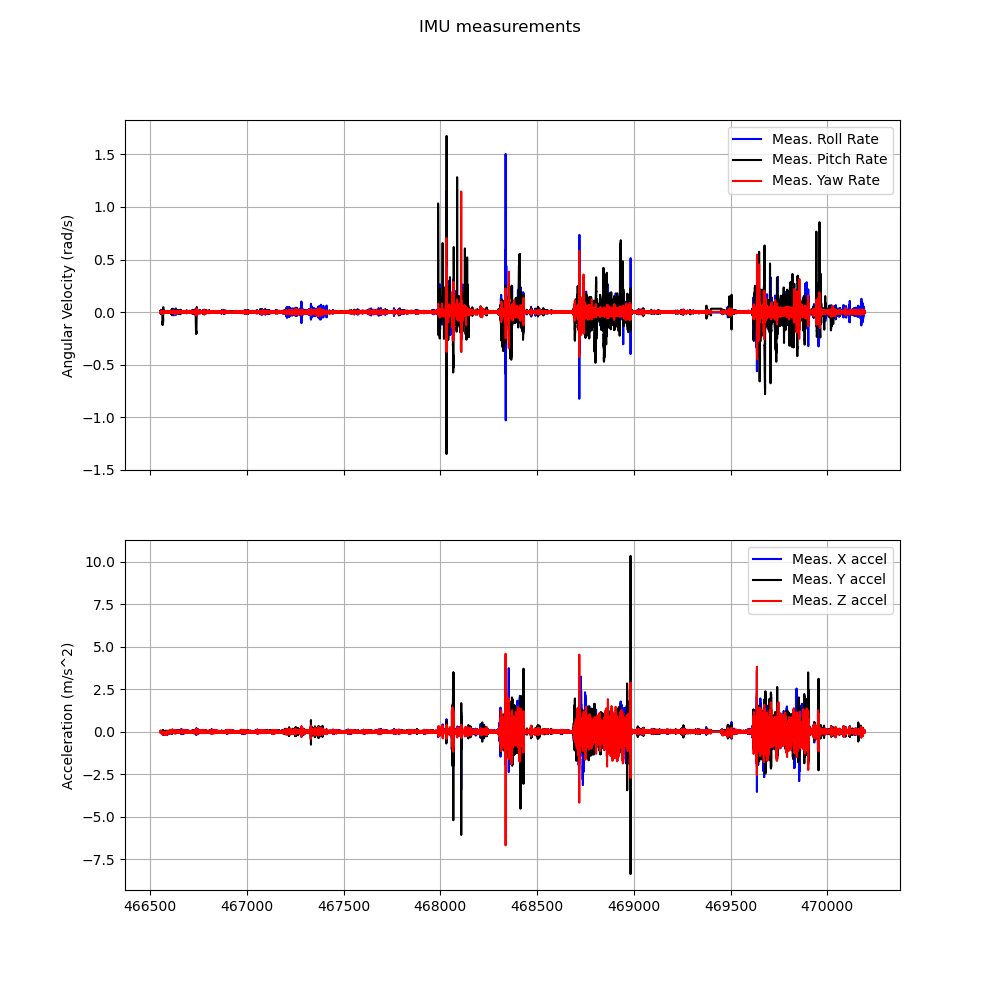

Read data into in_profile_array
 
Initializing Navigation States...
 
Initial Conditions:
Start time: 467000.0
Latitude (rad): -0.3707317815293877
Longitude (rad): 0.2596507219280116
UAV altitude (m): 901.4348
UAV attitude (rad): [-1.55118694  0.02158012  0.284334  ]
UAV vel_ned (m/s): [-0.00435 -0.00543 -0.01799]
 


[========================================================================] 100%


The Result is exported to:  C:/Users/bourriz/GNSS_INS_Processing/UIS_PosPac_HyspexNav_processing/Result/Position/Position_Attitude.csv


In [13]:
print('Reading data from IMU & GNSS...')

no_epochs, in_profile_data, InitParms = get_all_INS_GNSS_data(True)

print('Read data into in_profile_array')

print(' ')
print('Initializing Navigation States...')
print(' ')

class data_packet:
    def __init__(self):
        # GPS position measurement standard deviation per axis
        self.GNSS_NED_pos_sigma = InitParms[0]
        # GPS velocity measurement standard deviation per axis
        self.GNSS_NED_vel_sigma = InitParms[1]  # m/s
        # Attiude uncert
        self.init_att_unc = 10 * DTOR #10.0 * DTOR  # rad

        # Initial accelerometer bias per axis

        self.init_accel_bias = InitParms[2]
        # Accelerometer Markov bias standard deviation
        
        self.accel_markov_bias_sigma = 0.0005  # Times G!!!
        # Accelerometer time constant bias
        self.accel_TC_bias = 300.0  # sec
        
        #self.accel_meas_sigma = 0.12  # TIMES G!!!
        self.accel_meas_sigma = InitParms[3]/9.8
        # Initial gyroscope bias per axis
        
        self.init_gyro_bias = InitParms[4]
        # Gyroscope Markov bias standard deviation
        self.gyro_markov_bias_sigma = 0.3 * DTOR
        # Gyroscope time constant bias
        self.gyro_TC_bias = 300.0  # sec
        # Gyroscope measurement noise standard deviation
        self.gyro_meas_sigma = InitParms[5]

KF_param = data_packet()

# Initialize true navigation solution to first reading
old_time = in_profile_data[0][0]                # current time
old_latR = in_profile_data[0][1]                # lat is first GPS reading
old_longR = in_profile_data[0][2]               # Long is first GPS reading
old_alt = in_profile_data[0][3]                 # alt is first GPS reading
old_eul_nb = in_profile_data[0][13:16]
old_C_b_n = Euler_to_CTM(old_eul_nb)    # old CTM
old_v_eb_n = in_profile_data[0][4:7]            # vel ned is first GPS reading
first_omega_ib_b = in_profile_data[0][7:10]     # first gyro measurement
first_f_ib_b = in_profile_data[0][10:13]        # first accel measurement

index = 0

# Find NED frame ECEF reference
latR_base = old_latR
longR_base = old_longR
alt_base = 0.0  # assume base is at zero alt?
xB, yB, zB =LLA_to_ECEF(latR_base, longR_base, alt_base)
ECEF_ref = np.array([xB, yB, zB])

# Initialize IMU bias states
est_IMU_bias = np.array([KF_param.init_accel_bias.T,
                         KF_param.init_gyro_bias.T])

# Initialize output profile data array
out_profile_data = np.zeros((no_epochs, 19))
out_profile_data[0][0] = old_time
out_profile_data[0][1:4] = old_eul_nb.T*RTOD
out_profile_data[0][4:7] = old_v_eb_n.T
out_profile_data[0][7] = old_latR*RTOD
out_profile_data[0][8] = old_longR*RTOD
out_profile_data[0][9] = old_alt
out_profile_data[0][10] = 0.0  # Initial NED frame pos
out_profile_data[0][11] = 0.0
out_profile_data[0][12] = -old_alt  # - Down
out_profile_data[0][13:16] = est_IMU_bias[0]
out_profile_data[0][16:19] = est_IMU_bias[1]

GNSS_NED = np.zeros((no_epochs, 3))
INS_NED = np.zeros((no_epochs, 3))
v_eb_b = np.zeros((no_epochs, 3))
new_meas_heading_n = np.zeros(no_epochs)
VelEast = np.zeros(no_epochs)
VelNorth = np.zeros(no_epochs)
PreviousPoint = np.zeros((no_epochs, 2))

# Initialize GNSS timing model
GNSS_epoch_interval = 0.2  # Hz of GNSS Receiver (0.1)
time_last_GNSS = old_time
#time_last_GNSS = 469440
GNSS_epoch = 1

print('Initial Conditions:')
print('===================')
print('Start time: ' + str(old_time))
print('Latitude (rad): ' + str(old_latR))
print('Longitude (rad): ' + str(old_longR))
print('UAV altitude (m): ' + str(old_alt))
print('UAV attitude (rad): ' + str(old_eul_nb.T))
print('UAV vel_ned (m/s): ' + str(old_v_eb_n.T))
print(' ')

#Compute Noise Covariance Matrices

P = initialize_P_EKF(KF_param)

#Error State EKF

bar = progressbar.ProgressBar(maxval=no_epochs,
                              widgets=[progressbar.Bar('=', '[', ']'),
                                       ' ', progressbar.Percentage()])
bar.start()

for epoch in range(1, no_epochs):

    # Input data from motion profile array (use epoch k-1 to compute epoch k)
    time = in_profile_data[epoch][0]
    meas_latR = in_profile_data[epoch][1]               #measured GnSS Latitude
    meas_longR = in_profile_data[epoch][2]              #measured GNSS Longitude
    meas_alt = in_profile_data[epoch][3]                #measured GNSS Altitude
    meas_v_eb_n = in_profile_data[epoch][4:7]           #measured GNSS Velociteies (X/Y/Z) in navigation frame
    meas_omega_ib_b = in_profile_data[epoch][7:10]      #measured rates (Roll/Pitch/Yaw) through gyros in body frame
    meas_f_ib_b = in_profile_data[epoch][10:13]         #measured acceleration (X/Y/Z) through accelerometers in body frame

    # Time interval of INS
    tor_i = time - old_time

    # Correct the IMU errors (biases)
    meas_f_ib_b = meas_f_ib_b + est_IMU_bias[0]
    meas_omega_ib_b = meas_omega_ib_b + est_IMU_bias[1]

    # Update estimated INS Solution
    est_C_b_n, est_v_eb_n, est_latR, est_longR, est_alt = INS_Equations_NED(tor_i, old_latR, old_longR, old_alt, old_v_eb_n, old_C_b_n, meas_omega_ib_b, meas_f_ib_b, new_meas_heading_n[epoch-1]*DTOR)

    # Compute INS solution in NED frame
    xE, yE, zE = LLA_to_ECEF(est_latR, est_longR, est_alt)
    r_eb_e = np.zeros((3, 1))
    r_eb_e = np.array([xE, yE, zE])
    est_ned = np.zeros((3, 1))
    est_ned = ECEF_to_NED(r_eb_e, latR_base, longR_base, alt_base)
    INS_NED[epoch] = est_ned.T  # Vector for plotting purposes

    # Convert CURRENT GPS measured pos to NED (for innovation)
    new_meas_latR = in_profile_data[epoch][1]
    new_meas_longR = in_profile_data[epoch][2]
    new_meas_alt = in_profile_data[epoch][3]
    new_meas_v_eb_n = in_profile_data[epoch][6]
  
    xE, yE, zE = LLA_to_ECEF(new_meas_latR, new_meas_longR, new_meas_alt)
    r_eb_e = np.zeros((3, 1))
    r_eb_e = np.array([xE, yE, zE])
    GNSS_ned = np.zeros((3, 1))
    GNSS_ned = ECEF_to_NED(r_eb_e, latR_base, longR_base, alt_base)
    GNSS_NED[epoch] = GNSS_ned.T  # Vector for plotting purposes

    # Linearize and discretize error model
    A, F, Q, H, R = Get_dem_EKF_matrices(KF_param, tor_i, old_latR, old_alt,
                                          old_v_eb_n, old_C_b_n, meas_f_ib_b)

   

    # Compute prediction step
    P = prediction_step(F, P, Q)
    
    #As[n_epoch] = A             #State Transition Matrix


    if (time - time_last_GNSS) >= GNSS_epoch_interval:
        GNSS_epoch = GNSS_epoch + 1
        tor_s = time - time_last_GNSS  # EKF time interval
        time_last_GNSS = time

        # Compute correction step for errors
        P, K = correction_step(P, H, R)

        # Calculate Innovation
        delta_x = innovation(K, est_ned, GNSS_ned, est_v_eb_n, meas_v_eb_n)

        # Update INS solution with estimated errors
        est_latR, est_longR, est_alt, est_v_eb_n, est_C_b_n, est_IMU_bias =correct_NED_errors(delta_x, est_C_b_n, est_IMU_bias, old_latR, est_latR, est_longR, est_alt, new_meas_alt, est_v_eb_n, new_meas_v_eb_n)
    
    # Convert LLA position solution to NED
    xE, yE, zE = LLA_to_ECEF(est_latR, est_longR, est_alt)
    r_eb_e = np.zeros((3, 1))
    r_eb_e = np.array([xE, yE, zE])
    P_n = LLA_to_NED(latR_base, longR_base, alt_base, r_eb_e, ECEF_ref)
    if epoch == 0:
        new_meas_heading_n[0] = 1.5
        index = 0
    else:
        Range = 100
        while(Range>10 and index < epoch):
            Range = ma.sqrt((out_profile_data[index][10] - P_n[0])**2+(out_profile_data[index][11] - P_n[1])**2)
            if Range > 10:
                index += 1
        PreviousPoint[epoch][0] = P_n[1]
        PreviousPoint[epoch][1] = P_n[2]
        NorthD = out_profile_data[index-1][10]-P_n[0]
        EastD = out_profile_data[index-1][11]-P_n[1]

        new_meas_heading_n[epoch] = (ma.atan2(-EastD, -NorthD) + np.pi)*RTOD


    # Record ouput data record
    out_profile_data[epoch][0] = time  #Time
    out_profile_data[epoch][1:4] = CTM_to_Euler(est_C_b_n).T*RTOD  #Roll Pitch Yaw
    out_profile_data[epoch][3] = (out_profile_data[epoch][3] + 360) % 360 
    out_profile_data[epoch][4:7] = est_v_eb_n.T #Velocity ve vn vd
    out_profile_data[epoch][7] = est_latR*RTOD #Latitude
    out_profile_data[epoch][8] = est_longR*RTOD # Longitude
    out_profile_data[epoch][9] = est_alt # Altitude
    out_profile_data[epoch][10] = P_n[0]
    out_profile_data[epoch][11] = P_n[1]
    out_profile_data[epoch][12] = P_n[2]
    out_profile_data[epoch][13:16] = est_IMU_bias[0]
    out_profile_data[epoch][16:19] = est_IMU_bias[1]  

    # Reset old values
    old_time = time
    old_C_b_n = est_C_b_n
    old_v_eb_n = est_v_eb_n
    old_latR = est_latR
    old_longR = est_longR
    old_alt = est_alt

    bar.update(epoch)

bar.finish()

# Create a CSV file and write on it  the output
csv_file_path = folder+"/Position_Attitude.csv"

# Headers for the CSV
headers = ["time", "latitude", "longitude","Height" ,"velocity_N", "velocity_E", "velocity_D", "roll", "pitch", "yaw"]
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write the headers
    csv_writer.writerow(headers)
    
    # Loop through the rows of out_profile_data and write to CSV
    for row in out_profile_data:
        csv_writer.writerow([
            row[0],      # time
            row[7],      # latitude
            row[8],      # longitude
            row[9],      # Height
            row[4],      # velocity_x
            row[5],      # velocity_y
            row[6],      # velocity_z
            row[1],      # roll
            row[2],      # pitch
            row[3]       # yaw
        ])

# Return the CSV file path
print('The Result is exported to: ',csv_file_path)


## Visualization of the results

In [14]:
#POSPac data
Pospac_PP = pd.read_csv(folder+'/export_Mission 1-pp.txt', delimiter = "\s+",header=None)
Time=Pospac_PP[0]
X=Pospac_PP[2]
Y=Pospac_PP[3]
Z=Pospac_PP[4]
latitude=Pospac_PP[5]
longitude=Pospac_PP[6]
Roll=Pospac_PP[8]
Pitch=Pospac_PP[9]
Heading=Pospac_PP[10]
Ve=Pospac_PP[11]
Vn=Pospac_PP[12]
Vd=Pospac_PP[13]
total_speed=np.sqrt(Ve**2+Vn**2+Vd**2)

In [15]:
fusion_result = pd.read_csv(folder+'/out_profile_data.csv')

In [16]:
#Projection tu UTM 33 S

time=fusion_result['time']
latitude=fusion_result['latitude']
longitude=fusion_result['longitude']
transformer=Transformer.from_crs('EPSG:4326','EPSG:32733',always_xy=True)

Easting,Northing=transformer.transform(longitude,latitude)

d={'time': time,'Easting': Easting,'Northing': Northing}
utm_coords=pd.DataFrame(data=d)
fusion_result=fusion_result.merge(utm_coords)
fusion_result.head(5)

,time,latitude,longitude,Height,velocity_N,velocity_E,velocity_D,roll,pitch,yaw,Easting,Northing
0,467000.00,-21.241366,14.876891,901.4348,-0.004350,-0.005430,-0.01799,-88.876465,1.236450,16.291138,487226.052157,7.651134e+06
1,467000.01,-21.241366,14.876891,901.4348,-0.004413,-0.005612,-0.01799,-88.872674,1.236889,16.290010,487226.052102,7.651134e+06
2,467000.02,-21.241366,14.876891,901.4348,-0.004361,-0.005968,-0.01799,-88.868275,1.237266,16.288138,487226.052046,7.651134e+06
3,467000.03,-21.241366,14.876891,901.4348,-0.004704,-0.006296,-0.01799,-88.864059,1.238921,16.286799,487226.051987,7.651134e+06
4,467000.04,-21.241366,14.876891,901.4348,-0.005430,-0.006641,-0.01799,-88.860514,1.240347,16.285143,487226.051924,7.651134e+06


In [17]:
# Convert the time data into a TimedeltaIndex for profile_data
fusion_result.set_index('time', inplace=True)
fusion_result.index = pd.to_timedelta(fusion_result.index, unit='s')

# Resample the profile_data to match the frequency of mission_data and interpolate missing values
resampled_fusion_result = fusion_result.resample('5ms').interpolate()

# Convert the TimedeltaIndex back to float for consistency with the original data
resampled_fusion_result.reset_index(inplace=True)
resampled_fusion_result['time'] = resampled_fusion_result['time'].dt.total_seconds()

In [18]:
# Interpolation for resampling using scipy
start_time = 468360.00736
end_time = 469398.65356
resample_times = Time[(Time.astype(float) >= start_time) & (Time.astype(float) <= end_time)].astype(float)
interpolated_data = {}
for column in resampled_fusion_result.columns[1:]:
    interpolator = interp1d(resampled_fusion_result['time'], resampled_fusion_result[column], kind='linear', fill_value="extrapolate")
    interpolated_data[column] = interpolator(resample_times)
interpolated_fusion_result = pd.DataFrame(interpolated_data)
interpolated_fusion_result.insert(0, 'time', resample_times)

In [19]:
time=interpolated_fusion_result['time']
Easting_es=interpolated_fusion_result['Easting']
Northing_es=interpolated_fusion_result['Northing']
latitude_es=interpolated_fusion_result['latitude']
longitude_es=interpolated_fusion_result['longitude']
height_es=interpolated_fusion_result['Height']
velocity_N_es=interpolated_fusion_result['velocity_N']
velocity_E_es=interpolated_fusion_result['velocity_E']
velocity_D_es=interpolated_fusion_result['velocity_D']
total_speed_es=np.sqrt(velocity_N_es**2+velocity_E_es**2+velocity_D_es**2)
roll_es=interpolated_fusion_result['roll']
pitch_es=interpolated_fusion_result['pitch']
heading_es=interpolated_fusion_result['yaw']

Text(0.5, 0.98, 'GNSS/INS Fusion Results')

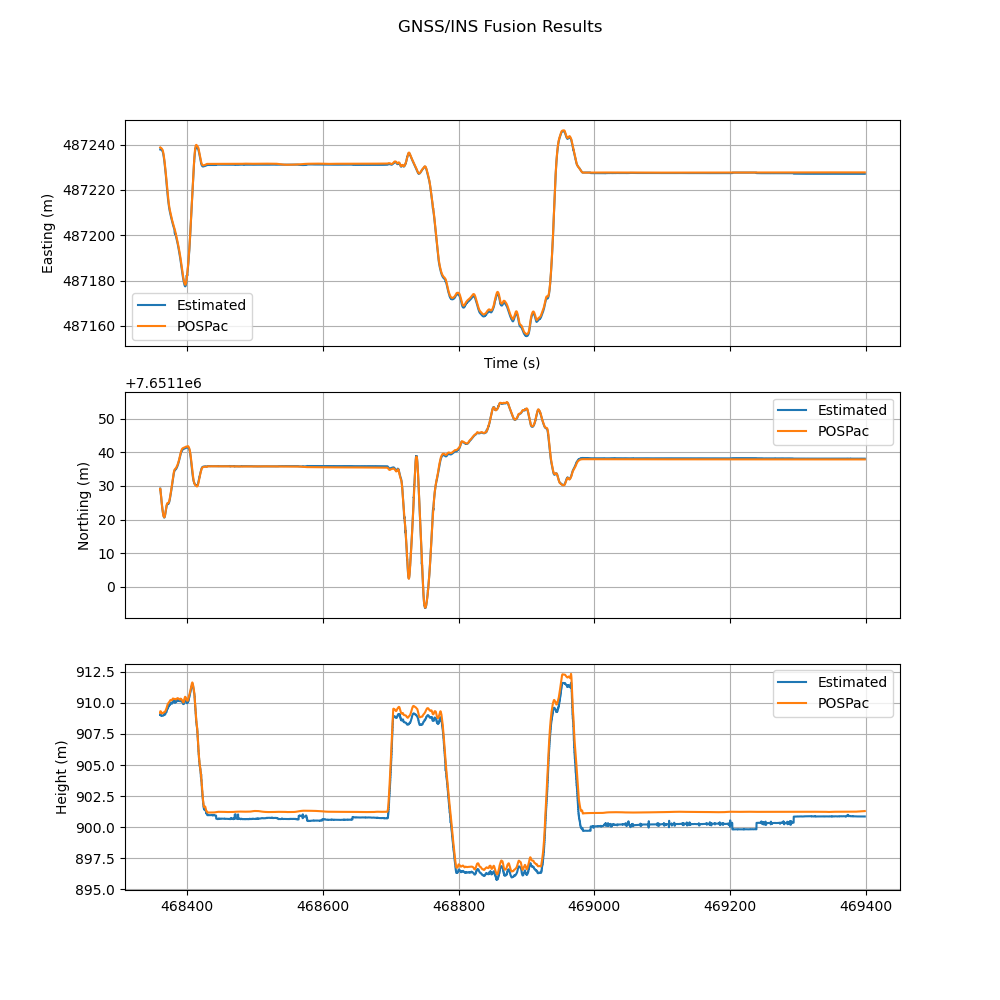

In [20]:
fig, a = plt.subplots(3, figsize=(10, 10),sharex=True)
a[0].plot(time,Easting_es,label='Estimated')
a[0].plot(time,X,label='POSPac')
a[0].grid()
a[0].set_xlabel('Time (s)')
a[0].set_ylabel('Easting (m)')
a[0].legend()

a[1].plot(time,Northing_es,label='Estimated')
a[1].plot(Time,Y,label='POSPac')
a[1].grid()
a[1].set_ylabel('Northing (m)')
a[1].legend()

a[2].plot(time,height_es,label='Estimated')
a[2].plot(time,Z,label='POSPac')
a[2].grid()
a[2].set_ylabel('Height (m)')
a[2].legend()

fig.suptitle('GNSS/INS Fusion Results')

Text(0.5, 0.98, 'GNSS/INS Fusion Results')

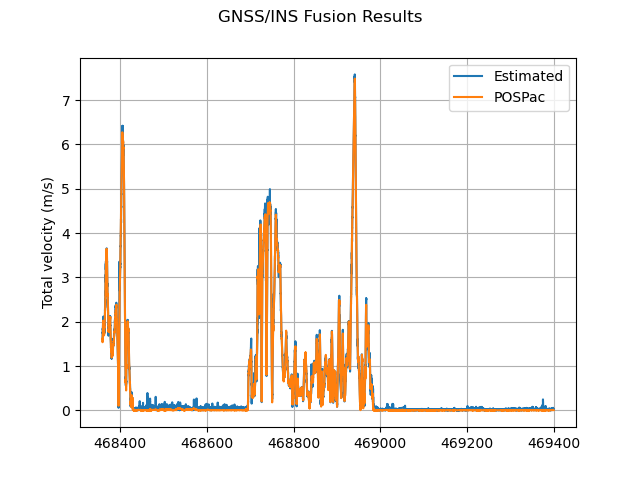

In [21]:
fig, a = plt.subplots()
a.plot(time,total_speed_es,label='Estimated')
a.plot(Time,total_speed,label='POSPac')
a.grid()
a.legend()
a.set_ylabel('Total velocity (m/s)')
fig.suptitle('GNSS/INS Fusion Results')

Text(0.5, 0.98, 'GNSS/INS Fusion Results')

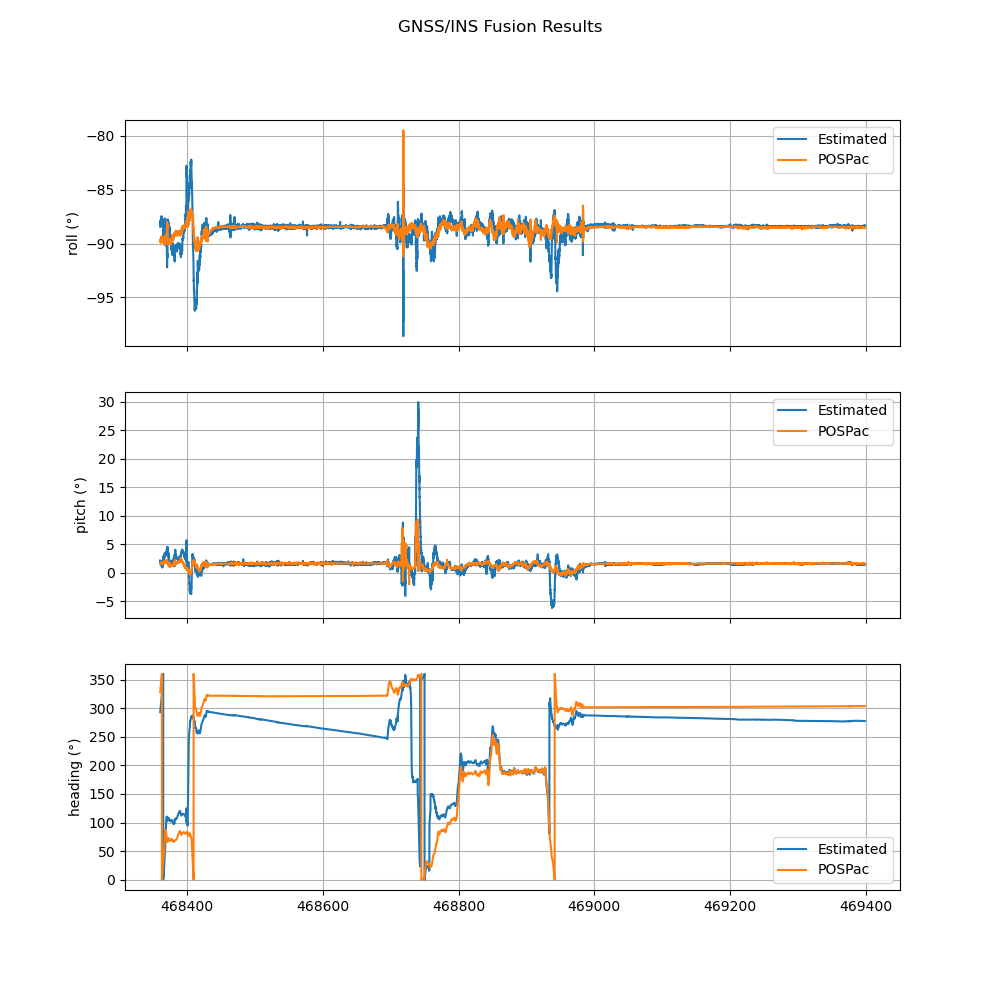

In [22]:
fig, a = plt.subplots(3, figsize=(10, 10),sharex=True)
a[0].plot(time,roll_es,label='Estimated')
a[0].plot(Time,Roll,label='POSPac')
a[0].grid()
a[0].legend()
a[0].set_ylabel('roll (°)')

a[1].plot(time,pitch_es,label='Estimated')
a[1].plot(Time,Pitch,label='POSPac')
a[1].grid()
a[1].set_ylabel('pitch (°)')
a[1].legend()

a[2].plot(time,heading_es,label='Estimated')
a[2].plot(Time,Heading,label='POSPac')
a[2].grid()
a[2].set_ylabel('heading (°)')
a[2].legend()
fig.suptitle('GNSS/INS Fusion Results')